**Bài này có 04 gợi ý:**
1. Chosen plaintext attack (CPA): Là một mô hình tấn công mà kẻ tấn công có khả năng chọn một số bản rõ (plaintext) và yêu cầu hệ thống mã hóa (encryption system) mã hóa các bản rõ này. Dựa trên các bản mã (ciphertext) thu được, kẻ tấn công cố gắng rút ra thông tin về khóa mã hóa hoặc thuật toán mã hóa nhằm phá vỡ tính bảo mật của hệ thống.

2. Sử dụng OpenSSL để giải mã thông điệp. Ex: `openssl enc -aes-256-cbc -d ...`

3. Chìa khóa để lấy được cờ là gửi một thông báo tùy chỉnh đến máy chủ bằng cách tận dụng thuật toán mã hóa RSA.

4. Yêu cầu tối thiểu đối với một hệ thống mật mã hữu ích là bảo mật CPA: Nghĩa là, một hệ thống mật mã cần đảm bảo rằng, ngay cả khi kẻ tấn công có quyền truy cập vào hệ thống để mã hóa các bản rõ (plaintext) tùy ý, thì kẻ tấn công cũng không thể suy luận ra bất kỳ thông tin hữu ích nào về khóa bí mật hoặc các bản rõ khác.

**Yêu cầu:** Decrypt password và sử dụng nó để decrypt thông điệp

Thử nghiệm bằng netcat: nc titan.picoctf.net 52342, ta thu được:
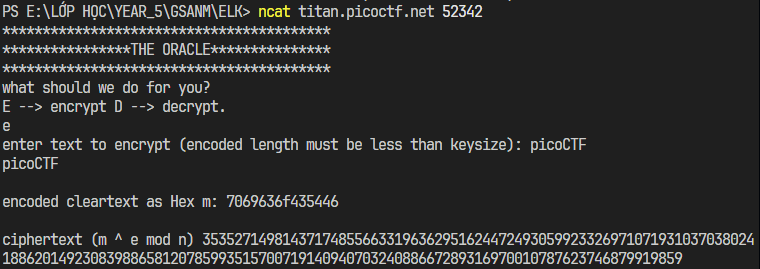

Quy trình yêu cầu ta chọn E (Encrypt) hoặc D (Decrypt). Khi ta thực hiện mã hóa, ta được một chuỗi dài, và hệ thống gợi ý rằng họ đang sử dụng RSA.

Chương trình hình như chuyển đổi plaintext thành mã hex rồi sau đó mới sử dụng RSA để mã hóa.

In [3]:
from Crypto.Util.number import *
from pwn import *
import decimal

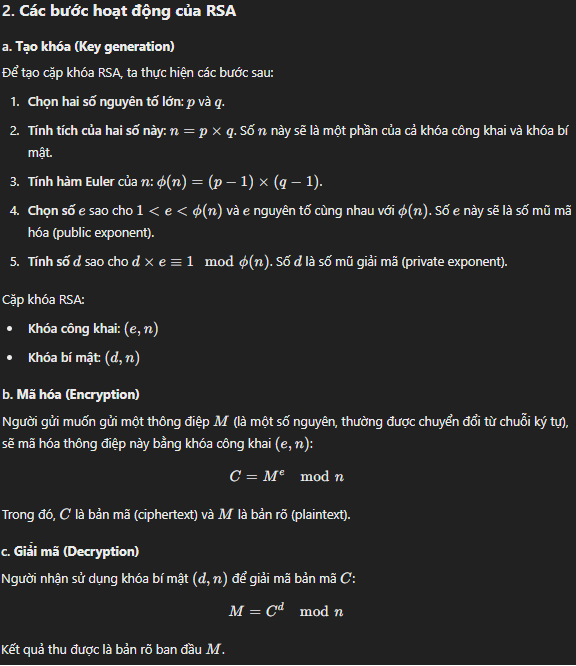

In [1]:
# Dữ liệu cho trước:
secret_enc = "Salted__�rF7�]�{O�e3L�b�A��h��,�Ո;u{�^�a��X�7�0��ծ0���2|l8O&7"               # Thông điệp được mã hóa
password_enc = "4228273471152570993857755209040611143227336245190875847649142807501848960847851973658239485570030833999780269457000091948785164374915942471027917017922546"             # Mật khẩu được lấy

In [ ]:
# nc titan.picoctf.net 52342
r = remote("titan.picoctf.net", 52342)
# Lấy dữ liệu
r.recvline(keepends=False).decode()

# Gửi dữ liệu đi
r.sendafter("to decrypt: ", "e")

In [ ]:
# Đây là lời giải, để đây. Ta sẽ viết hàm qua bên solution_rsa_oracle.py
from pwn import *

connection = remote('titan.picoctf.net', 56192)

# Get the first messages and send encrypt
response = connection.recvuntil('decrypt.')
print(response.decode())
payload = b'E' + b'\n'

connection.send(payload)

response = connection.recvuntil('keysize):')
print(response.decode())

# We want to encrypt the number 2
payload = b'\x02' + b'\n'
connection.send(payload)
response = connection.recvuntil('ciphertext (m ^ e mod n)')
response = connection.recvline()

# We now have 2^e, we want to multiply by m^e (from the file password.enc)
num=int(response.decode())*4228273471152570993857755209040611143227336245190875847649142807501848960847851973658239485570030833999780269457000091948785164374915942471027917017922546

# We now choose to decrypt
response = connection.recvuntil('decrypt.')
print(response.decode())
payload = b'D' + b'\n'
connection.send(payload)

# We decrypt 2^e*m^e, which will yield 2*m
response = connection.recvuntil('decrypt:')
print(response.decode())
connection.send(str(num)+'\n')

response = connection.recvuntil('hex (c ^ d mod n):')
print(response.decode())
response = connection.recvline()
print(response.decode())

# we grab the response, convert it from hexadecimal and divide by 2
num=int(response,16)//2
print(hex(num))

# Now we convert this to ASCII
hex_string=hex(num)[2:] # get rid of 0x
byte_array=bytes.fromhex(hex_string)
print(byte_array.decode('ascii'))

# Close the connection
connection.close()

In [ ]:
from pwn import *
from Crypto.Util.number import *
import subprocess
# import decimal

# Mã hóa openSSL:
def decrypt_file(input_file, password):
    command = [
        'openssl', 'enc', '-aes-256-cbc', '-d', '-in', input_file, '-k', password
    ]

    try:
        # Sử dụng subprocess để chạy câu lệnh và đọc kết quả từ stdout
        result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # In ra kết quả đã giải mã
        print(f"Result: {result.stdout}")

    except subprocess.CalledProcessError as e:
        # In ra lỗi nếu có vấn đề trong quá trình giải mã
        print(f"Lỗi khi giải mã file: {e.stderr}")

# Tạo một conection remote:
port = 55268
r = remote('titan.picoctf.net', port)

# Đọc file về password:
with open('password.enc', 'r') as file:
    password_enc = int(file.read().strip())

# Gửi yêu cầu mã hóa: E, sau đó gửi dữ liệu mã hóa là số 2 đi:
enc_sym = b'E' + b'\n' 
dec_sym = b'D' + b'\n' 

payload = b'\x02' + b'\n'

get_success = r.recvuntil('decrypt.').decode()
r.send(enc_sym)                 # r.sendline(b'E')
get_success = r.recvuntil('keysize):').decode()
r.send(payload)

# Vì server gửi ra quá nhiều dòng, do đó, ta sẽ thực hiện lấy dữ liệu mã hóa của 2 bằng cách lắng nghe để gọn code:
get_success = r.recvuntil('ciphertext (m ^ e mod n)').decode()
enc_2 = r.recvline(keepends=False).decode()

# Nhân 2 giá trị encode vào và thực hiện quá trình giải mã:
text_dec = int(enc_2) * password_enc
text_dec = str(text_dec).encode() + b'\n'

# Thực hiện decrypt:
get_success = r.recvuntil('decrypt.').decode()
r.send(dec_sym)      
get_success = r.recvuntil('decrypt:').decode()
r.send(text_dec)

# Lấy dữ liệu decrypt:
get_success = r.recvuntil('hex (c ^ d mod n):').decode()
num_dec = r.recvline(keepends=False).strip().decode()     
get_success = r.recvuntil('decrypted ciphertext:').decode()
text_dec = r.recvline(keepends=False).strip().decode()    

# Chuyển đổi thành số nguyên (từ 16 --> 10), sau đó chia lấy phần nguyên với 2
num_dec = int(num_dec, 16)//2
print(num_dec)

# Chuyển lại thành hexa, sau đó bỏ số 0x. Cuối cùng chuyển về lại thành byte ASCII
hex_string = hex(num_dec)[2:]
byte_array = bytes.fromhex(hex_string)
text_dec = byte_array.decode('ascii')
print(text_dec, hex_string)

# Giải mã và in ra kết quả:
decrypt_file("secret.enc", text_dec)        

# Đóng chương trình:
r.close()

In [5]:
import subprocess

def decrypt_file(input_file, output_file, password):
    # Câu lệnh OpenSSL để giải mã file
    command = [
        'openssl', 'enc', '-aes-256-cbc', '-d', '-in', input_file, '-out', output_file, '-k', password
    ]

    try:
        # Chạy câu lệnh OpenSSL bằng subprocess
        result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(f"Giải mã thành công, dữ liệu đã được lưu vào {output_file}")
    except subprocess.CalledProcessError as e:
        # In ra lỗi nếu có vấn đề trong quá trình giải mã
        print(f"Lỗi khi giải mã file: {e.stderr.decode('utf-8')}")

if __name__ == "__main__":
    # Tên file mã hóa, file đầu ra, và mật khẩu
    input_file = 'secret.enc'    # Đường dẫn tới file mã hóa
    output_file = 'decrypted.txt' # Đường dẫn file đầu ra
    password = 'da099'            # Mật khẩu

    # Gọi hàm để giải mã file
    decrypt_file(input_file, output_file, password)


Giải mã thành công, dữ liệu đã được lưu vào decrypted.txt
